In [721]:
import math
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import netCDF4

In [722]:
Training_Images = np.load('/fast/gmooers/Preprocessed_Data/W_Trial/Space_Time_W_Training.npy')
Test_Images = np.load('/fast/gmooers/Preprocessed_Data/W_Trial/Space_Time_W_Test.npy')

Max_Scalar = np.load('/fast/gmooers/Preprocessed_Data/W_Trial/Space_Time_Max_Scalar.npy')
Min_Scalar = np.load('/fast/gmooers/Preprocessed_Data/W_Trial/Space_Time_Min_Scalar.npy')

In [725]:
print(Test_Images.shape)

(2093, 30, 128)


In [723]:
import keras
from keras import layers
from keras import backend as K
from keras.models import Model
from keras.losses import binary_crossentropy
import tensorflow as tf
from keras.utils import plot_model

In [724]:
class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var))*K.exp(log_var/2)+mean

In [681]:
#latent dim
codings_size = 2

batch_size = 128
img_width = len(Training_Images[0])
img_height = len(Training_Images[0][0])
inputs = keras.layers.Input(shape=[img_height, image_width])
z = keras.layers.Flatten()(inputs)
z = keras.layers.Dense(150, activation="selu")(z)
z = keras.layers.Dense(100, activation="selu")(z)
codings_mean = keras.layers.Dense(codings_size)(z)
codings_log_var = keras.layers.Dense(codings_size)(z)
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = keras.Model(inputs = [inputs], outputs=[codings_mean, codings_log_var, codings])

In [682]:
decoder_inputs = keras.layers.Input(shape=[codings_size])
x = keras.layers.Dense(100, activation="selu")(decoder_inputs)
x = keras.layers.Dense(150, activation="selu")(x)
x = keras.layers.Dense(30*128, activation="sigmoid")(x)
outputs = keras.layers.Reshape([30,128])(x)
variational_decoder = keras.Model(inputs=[decoder_inputs], outputs=[outputs])

In [683]:
_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = keras.Model(inputs=[inputs], outputs=[reconstructions])

https://stats.stackexchange.com/questions/300304/variational-autoencoder-and-validation-loss

http://www.matthey.me/pdf/betavae_iclr_2017.pdf

https://openreview.net/pdf?id=BJe0Gn0cY7

https://openreview.net/pdf?id=r1xaVLUYuE

In [684]:
def kl_reconstruction_loss(true, pred):
    # Reconstruction loss
    reconstruction_loss = binary_crossentropy(K.flatten(true), K.flatten(pred)) * img_width * img_height
    # KL divergence loss
    kl_loss = 1 + codings_log_var - K.square(codings_mean) - K.exp(codings_log_var)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    # Total loss = 50% rec + 50% KL divergence loss
    #On ruihan's advice, I will weight KL down
    kl_weight = 0.1
    return K.mean(reconstruction_loss + kl_weight*kl_loss)
    #return K.mean(reconstruction_loss + kl_loss)


def kl(true, pred):
    kl_loss = 1 + codings_log_var - K.square(codings_mean) - K.exp(codings_log_var)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    return kl_loss

def reconstruction(true, pred):
    # Reconstruction loss
    reconstruction_loss = binary_crossentropy(K.flatten(true), K.flatten(pred)) * img_width * img_height
    return reconstruction_loss

How to plot multiple losses - suprisingly difficult in keras

https://stackoverflow.com/questions/44298955/tracking-multiple-losses-with-keras

In [685]:
#latent_loss = -0.5*K.sum(1+codings_log_var - K.exp(codings_log_var) - K.square(codings_mean), axis = -1)
#variational_ae.add_loss(K.mean(latent_loss)/784.)
variational_ae.compile(loss=kl_reconstruction_loss, optimizer ="rmsprop", metrics=[kl, reconstruction])
variational_ae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_57 (InputLayer)        (None, 30, 128)           0         
_________________________________________________________________
model_85 (Model)             [(None, 2), (None, 2), (N 591654    
_________________________________________________________________
model_86 (Model)             (None, 30, 128)           595290    
Total params: 1,186,944
Trainable params: 1,186,944
Non-trainable params: 0
_________________________________________________________________


In [686]:
h = variational_ae.fit(Training_Images, Training_Images, epochs=60, batch_size=batch_size, validation_data=[Test_Images, Test_Images])

Train on 8371 samples, validate on 2093 samples
Epoch 1/60
8371/8371 [==============================] - 5s 548us/step - loss: 2268.0893 - kl: 80.4714 - reconstruction: 2260.0421 - val_loss: 2230.2938 - val_kl: 37.4735 - val_reconstruction: 2226.5465
Epoch 2/60
8371/8371 [==============================] - 1s 115us/step - loss: 2220.6622 - kl: 28.1351 - reconstruction: 2217.8487 - val_loss: 2216.8096 - val_kl: 11.0435 - val_reconstruction: 2215.7052
Epoch 3/60
8371/8371 [==============================] - 1s 114us/step - loss: 2219.0586 - kl: 16.7331 - reconstruction: 2217.3853 - val_loss: 2216.3870 - val_kl: 11.4709 - val_reconstruction: 2215.2399
Epoch 4/60
8371/8371 [==============================] - 1s 114us/step - loss: 2216.6977 - kl: 13.1552 - reconstruction: 2215.3822 - val_loss: 2215.9317 - val_kl: 12.2342 - val_reconstruction: 2214.7082
Epoch 5/60
8371/8371 [==============================] - 1s 117us/step - loss: 2215.8726 - kl: 9.2596 - reconstruction: 2214.9467 - val_loss: 221

In [687]:
plot_model(variational_encoder, to_file='W_Model_Structures/vae_W_encoder.png', show_shapes=True)
plot_model(variational_decoder, to_file='W_Model_Structures/vae_W_decoder.png', show_shapes=True)
plot_model(variational_ae, to_file='W_Model_Structures/vae_W.png', show_shapes=True)

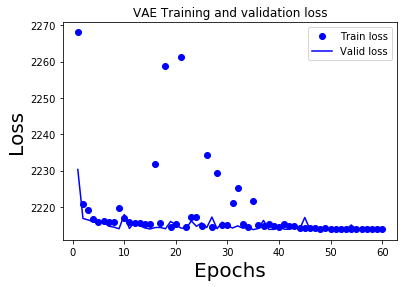

In [688]:
hdict1 = h.history
train_loss_values1 = hdict1['loss']
valid_loss_values1 = hdict1['val_loss']
epochs1 = range(1, len(train_loss_values1) + 1)
plt.plot(epochs1, train_loss_values1, 'bo', label='Train loss')
plt.plot(epochs1, valid_loss_values1, 'b', label='Valid loss')
plt.title('VAE Training and validation loss')
plt.xlabel('Epochs', fontsize = 20)
plt.ylabel('Loss', fontsize = 20)
#plt.yscale('log')
plt.legend()
plt.show()
plt.close()

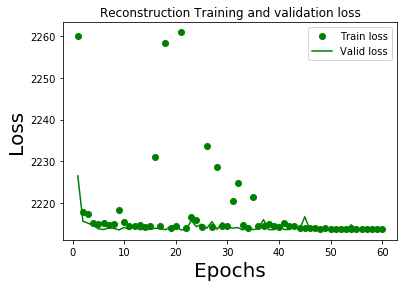

In [689]:
train_loss_values1 = hdict1['reconstruction']
valid_loss_values1 = hdict1['val_reconstruction']
epochs1 = range(1, len(train_loss_values1) + 1)
plt.plot(epochs1, train_loss_values1, 'go', label='Train loss')
plt.plot(epochs1, valid_loss_values1, 'g', label='Valid loss')
plt.title('Reconstruction Training and validation loss')
plt.xlabel('Epochs', fontsize = 20)
plt.ylabel('Loss', fontsize = 20)
#plt.yscale('log')
plt.legend()
plt.show()
plt.close()

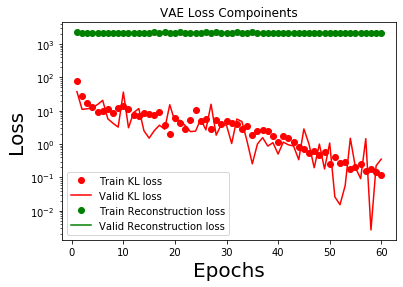

In [690]:
#make a plot for kl and reconstruction loss
kl_train_loss_values1 = hdict1['kl']
kl_valid_loss_values1 = hdict1['val_kl']
recon_train_loss_values1 = hdict1['reconstruction']
recon_valid_loss_values1 = hdict1['val_reconstruction']
epochs1 = range(1, len(train_loss_values1) + 1)
plt.plot(epochs1, kl_train_loss_values1, 'ro', label='Train KL loss')
plt.plot(epochs1, kl_valid_loss_values1, 'r', label='Valid KL loss')
plt.plot(epochs1, recon_train_loss_values1, 'go', label='Train Reconstruction loss')
plt.plot(epochs1, recon_valid_loss_values1, 'g', label='Valid Reconstruction loss')
plt.title('VAE Loss Compoinents')
plt.xlabel('Epochs', fontsize = 20)
plt.ylabel('Loss', fontsize = 20)
plt.yscale('log')
plt.legend()
plt.show()
plt.close()

## Sampling from the Latent Space

Linear Sampling

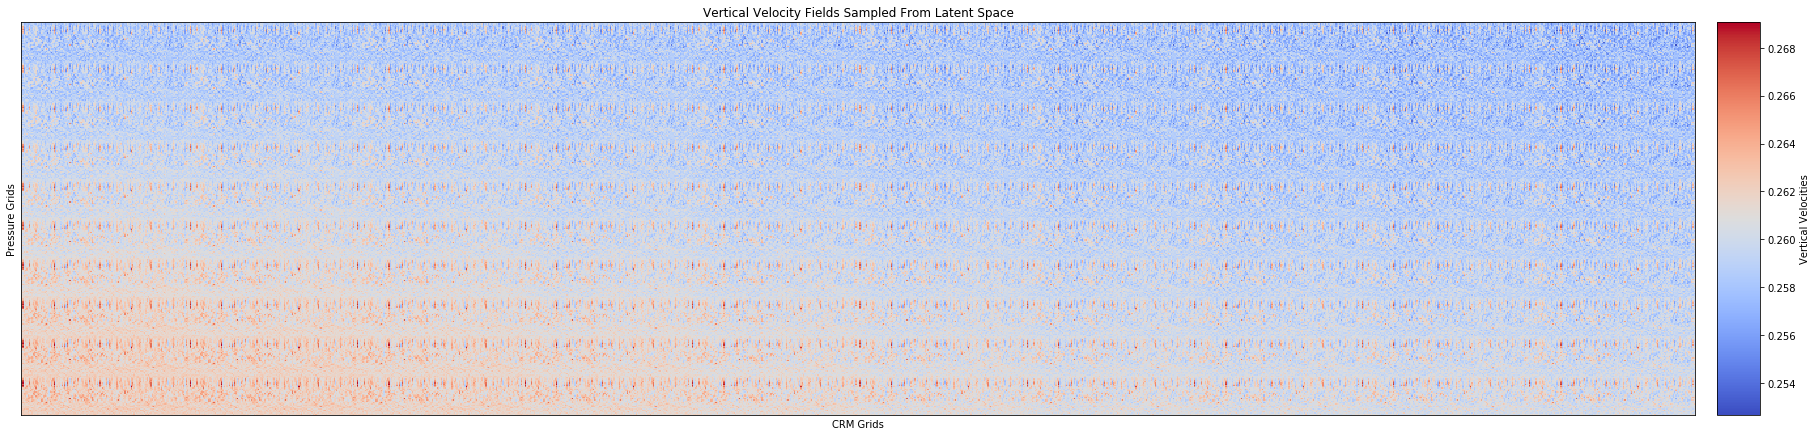

In [691]:
n = 10
digit_size_one = 30
digit_size_two = 128
figure = np.zeros((digit_size_one * n, digit_size_two * n))
grid_x = np.linspace(0.05, 0.95, n)
grid_y = np.linspace(0.05, 0.95, n)
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, codings_size)
        x_decoded = variational_decoder.predict(z_sample, batch_size=batch_size)
        x_decoded = np.interp(x_decoded, (0, 1), (Min_Scalar, Max_Scalar))
        digit = x_decoded[0].reshape(digit_size_one, digit_size_two)
        figure[i * digit_size_one: (i + 1) * digit_size_one,
            j * digit_size_two: (j + 1) * digit_size_two] = digit

fig = plt.figure(figsize=(30, 20))
ax = plt.axes()
my_plot = plt.imshow(figure, cmap='coolwarm')
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
plt.colorbar(my_plot, label = "Vertical Velocities", cax = cax)
ax.set_ylabel("Pressure Grids")
ax.set_xlabel("CRM Grids")
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("Vertical Velocity Fields Sampled From Latent Space")
plt.show()

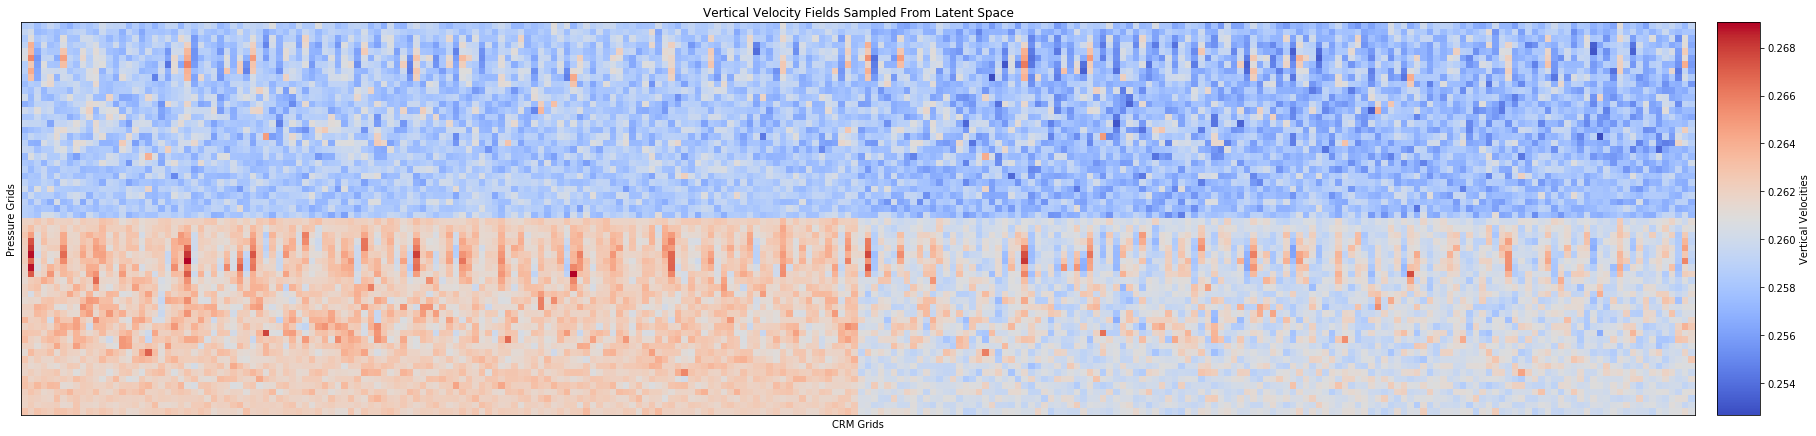

In [692]:
n = 2
digit_size_one = 30
digit_size_two = 128
figure = np.zeros((digit_size_one * n, digit_size_two * n))
grid_x = np.linspace(0.05, 0.95, n)
grid_y = np.linspace(0.05, 0.95, n)
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, codings_size)
        x_decoded = variational_decoder.predict(z_sample, batch_size=batch_size)
        x_decoded = np.interp(x_decoded, (0, 1), (Min_Scalar, Max_Scalar))
        digit = x_decoded[0].reshape(digit_size_one, digit_size_two)
        figure[i * digit_size_one: (i + 1) * digit_size_one,
            j * digit_size_two: (j + 1) * digit_size_two] = digit

fig = plt.figure(figsize=(30, 20))
ax = plt.axes()
my_plot = plt.imshow(figure, cmap='coolwarm')
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
plt.colorbar(my_plot, label = "Vertical Velocities", cax = cax)
ax.set_ylabel("Pressure Grids")
ax.set_xlabel("CRM Grids")
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("Vertical Velocity Fields Sampled From Latent Space")
plt.show()

Inverse CDF Sampling

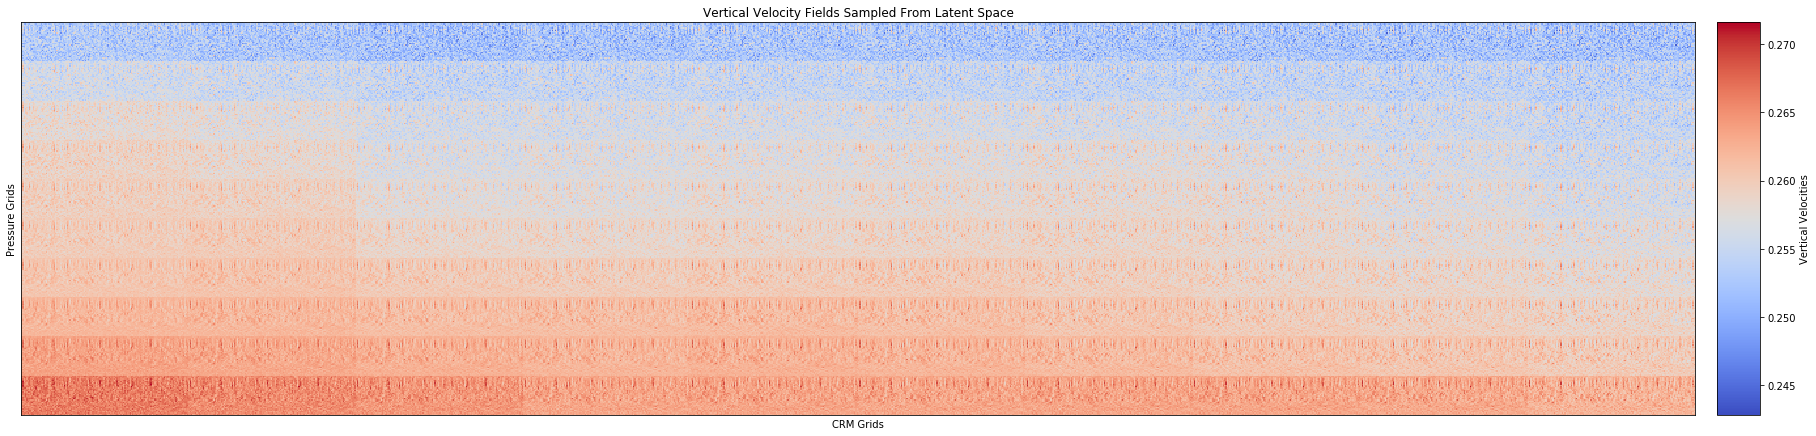

In [693]:
n = 10
digit_size_one = 30
digit_size_two = 128
figure = np.zeros((digit_size_one * n, digit_size_two * n))
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, codings_size)
        x_decoded = variational_decoder.predict(z_sample, batch_size=batch_size)
        xdecoded = np.interp(x_decoded, (0, 1), (Min_Scalar, Max_Scalar))
        digit = x_decoded[0].reshape(digit_size_one, digit_size_two)
        figure[i * digit_size_one: (i + 1) * digit_size_one,
            j * digit_size_two: (j + 1) * digit_size_two] = digit

fig = plt.figure(figsize=(30, 20))
ax = plt.axes()
my_plot = plt.imshow(figure, cmap='coolwarm')
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
plt.colorbar(my_plot, label = "Vertical Velocities", cax = cax)
ax.set_ylabel("Pressure Grids")
ax.set_xlabel("CRM Grids")
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("Vertical Velocity Fields Sampled From Latent Space")
plt.show()

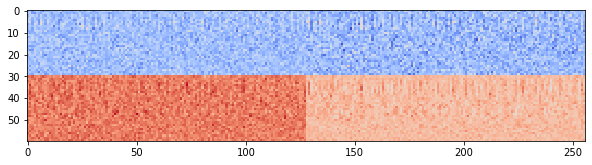

In [694]:
# display a 2D manifold of the digits
n = 2  # figure with 15x15 digits
digit_size_one = 30
digit_size_two = 128
# linearly spaced coordinates on the unit square were transformed
# through the inverse CDF (ppf) of the Gaussian to produce values
# of the latent variables z, since the prior of the latent space
# is Gaussian

z1 = norm.ppf(np.linspace(0.01, 0.99, n))
z2 = norm.ppf(np.linspace(0.01, 0.99, n))
z_grid = np.dstack(np.meshgrid(z1, z2))

x_pred_grid = variational_decoder.predict(z_grid.reshape(n*n, codings_size)) \
                     .reshape(n, n, digit_size_one, digit_size_two)

x_pred_grid = np.interp(x_pred_grid, (0, 1), (Min_Scalar, Max_Scalar))
plt.figure(figsize=(10, 10))
plt.imshow(np.block(list(map(list, x_pred_grid))), cmap='coolwarm')
plt.show()

## Latent Space Analysis

I need "y_test" here, but I have no idea what that would be in our problem? Some labeling scheme of updraft/downdraft?  Also, I need to better understand dimensionality of latent space - what is the first dimension here?

Second dim is # samples in test set

third dim is the dimensionality of the latent space - in this case 2

But what is that first dimension?

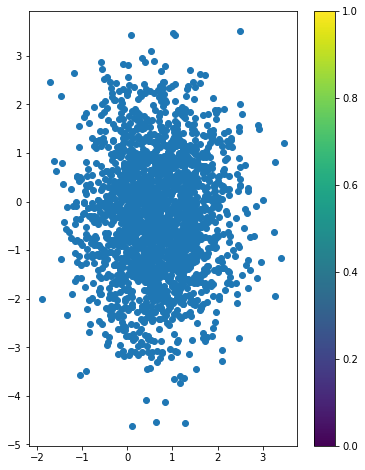

In [695]:
x_test_encoded = np.array(variational_encoder.predict(Test_Images, batch_size = batch_size))
plt.figure(figsize=(6,8))
#plt.scatter(x_test_encoded[:, 0], x_test_encoded[:,1])
plt.scatter(x_test_encoded[2, :,0], x_test_encoded[2, :,1])
plt.colorbar()
plt.savefig('W_Model_Structures/VAE_latent_Space.png')
plt.show()

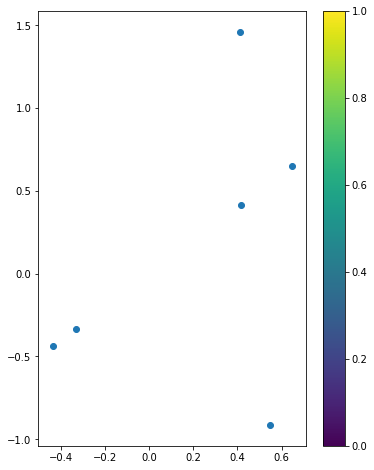

In [696]:
x_test_encoded = np.array(variational_encoder.predict(Test_Images, batch_size = batch_size))
plt.figure(figsize=(6,8))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:,1])
#plt.scatter(x_test_encoded[2, :,0], x_test_encoded[2, :,1])
plt.colorbar()
plt.savefig('W_Model_Structures/VAE_latent_Space.png')
plt.show()

## Truth to Prediction Comparisons

In [697]:
others = netCDF4.Dataset("/fast/gmooers/Raw_Data/extras/TimestepOutput_Neuralnet_SPCAM_216.cam.h1.2009-01-01-72000.nc")
plev = np.array(others.variables['lev'])
ps = np.array(others.variables['PS'])
g = 9.80616 #m/s^2
hyai = np.array(others.variables['hyai'])
hybi = np.array(others.variables['hybi'])
PS = 1e5
P0 = 1e5
P = P0*hyai+PS*hybi # Total pressure [Pa]
crm_spacing = (np.arange(0,128,1))
levs, lons = np.meshgrid(crm_spacing, P[:-1]/100.)

In [698]:
Predict_Images = variational_ae.predict(Test_Images, batch_size=batch_size)
Unscaled_Predict_Images = np.interp(Predict_Images, (0, 1), (Min_Scalar, Max_Scalar))
Unscaled_Test_Images = np.interp(Test_Images, (0, 1), (Min_Scalar, Max_Scalar))

In [699]:
print(np.max(Test_Images))
print(np.min(Test_Images))
print(np.max(Predict_Images))
print(np.min(Predict_Images))

0.9060817235862667
0.032688401774891476
0.28856537
0.23416796


In [700]:
print(np.max(Unscaled_Test_Images))
print(np.min(Unscaled_Test_Images))
print(np.max(Unscaled_Predict_Images))
print(np.min(Unscaled_Predict_Images))

21.606748580932617
-7.751070022583008
0.8498539320784175
-0.9786339724477102


I Want to make a side by side plot of the unormalized, normalized and prediction

In [701]:
def min_max_gen(truths, predictions):
    my_list = [truths, predictions]
    max_list = []
    min_list = []
    for i in range(len(my_list)):
        values = my_list[i].ravel()
        max_list.append(np.max(values))
        min_list.append(np.min(values))
        
    vmax = np.max(np.array(max_list))
    vmin = np.min(np.array(min_list))

    return vmin, vmax

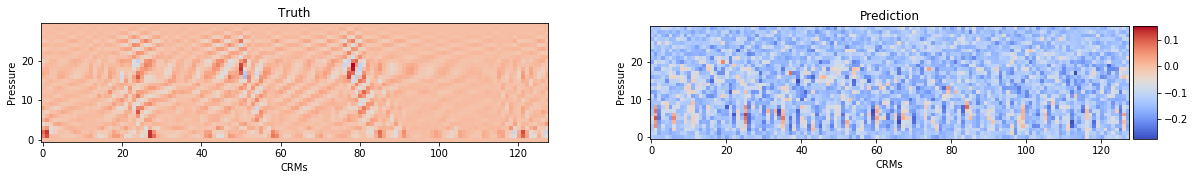

In [702]:
def comparison_gen(truth, pred, location):
    fig, axs = plt.subplots(1, 2, figsize=(20,26))
    cmap = 'coolwarm'
    image_index = location
    datasets = [truth, pred]
    var_labels = ["Truth", "Prediction"]
    count = 0
    vmin, vmax = min_max_gen(truth[image_index,:,:], pred[image_index,:,:])
    for ax in axs.ravel():
        cs = ax.imshow(np.squeeze(datasets[count][image_index,:,:]), cmap=cmap, vmin = vmin, vmax = vmax)
        if count == 1:
            divider = make_axes_locatable(ax)
            cax = divider.append_axes("right", size="5%", pad=0.05)
            fig.colorbar(cs, cax=cax)
        ax.set_ylim(ax.get_ylim()[::-1])
        ax.set_xlabel('CRMs')
        labels = [item.get_text() for item in ax.get_yticklabels()]
        labels = P  
        ax.set_ylabel('Pressure')
        ax.set_title(var_labels[count])
        count = count+1
        
comparison_gen(Unscaled_Test_Images, Unscaled_Predict_Images, 1915)

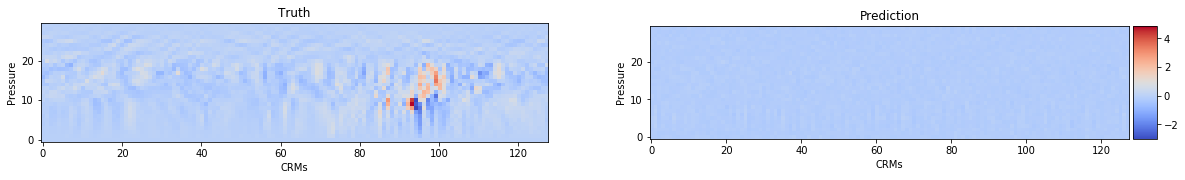

In [703]:
comparison_gen(Unscaled_Test_Images, Unscaled_Predict_Images, 1905)

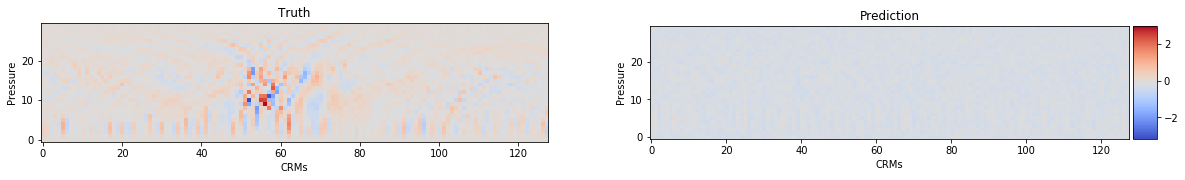

In [704]:
comparison_gen(Unscaled_Test_Images, Unscaled_Predict_Images, 1907)

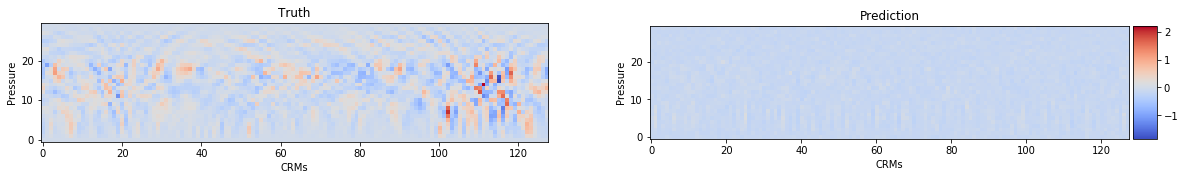

In [705]:
comparison_gen(Unscaled_Test_Images, Unscaled_Predict_Images, 1908)

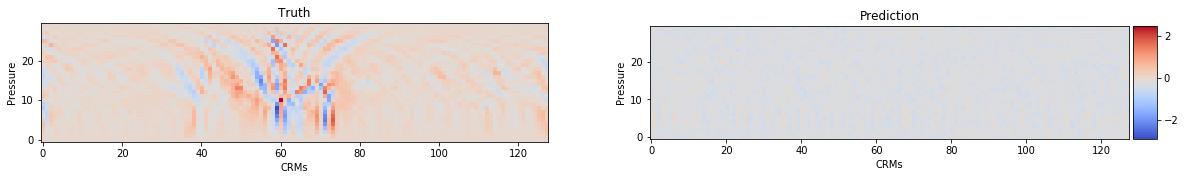

In [706]:
comparison_gen(Unscaled_Test_Images, Unscaled_Predict_Images, 1910)

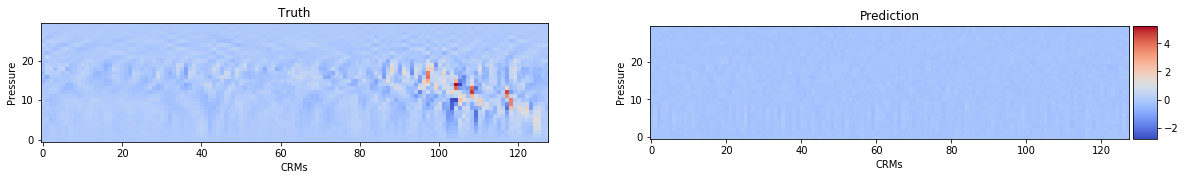

In [707]:
comparison_gen(Unscaled_Test_Images, Unscaled_Predict_Images, 1912)

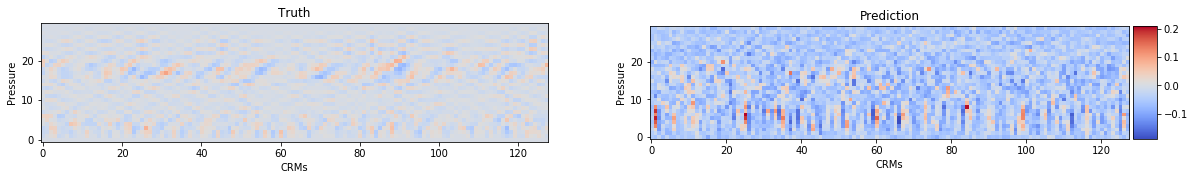

In [708]:
comparison_gen(Unscaled_Test_Images, Unscaled_Predict_Images, 1913)

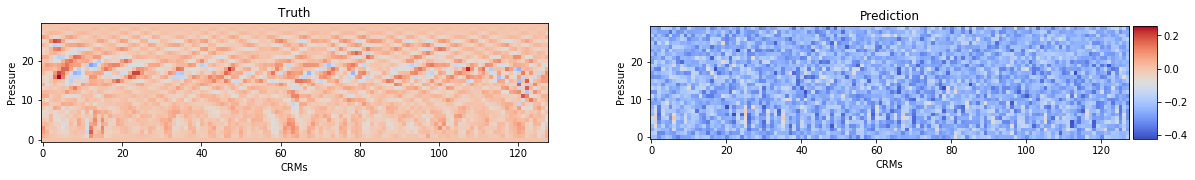

In [709]:
comparison_gen(Unscaled_Test_Images, Unscaled_Predict_Images, 1914)

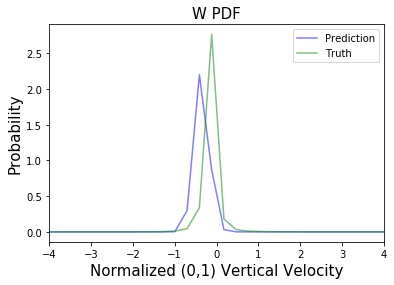

In [719]:
def pdf_gen(feat, targ):
    feat = feat.ravel()
    targ = targ.ravel()
    shared_bins = np.histogram_bin_edges(targ, bins=100)
    #print(shared_bins)
    freq, edges = np.histogram(feat, bins = shared_bins, density = True)
    freq_targ, edges_targ = np.histogram(targ, bins = shared_bins, density = True)

    
    fig, ax = plt.subplots()
    
    plt.plot(edges[:-1], freq,  label = "Prediction", alpha = 0.5, color = 'blue')
    plt.plot(edges_targ[:-1], freq_targ, label = "Truth", alpha = 0.5, color = 'green')

    plt.xlabel('Normalized (0,1) Vertical Velocity', fontsize = 15)
    plt.ylabel('Probability', fontsize = 15)
    plt.title('W PDF', fontsize = 15)
    plt.legend(loc = 'best')
    plt.xlim(-4, 4)
    #plt.xscale('log')
    #plt.yscale('log')
    
#pdf_gen(np.sort(f)[:61046784], np.sort(t)[:61046784], np.sort(c)[:61046784], m, M)
pdf_gen(Unscaled_Predict_Images, Unscaled_Test_Images)

In [712]:
print(np.max(Predict_Images))

0.28856537


In [720]:
del variational_ae